In [89]:
# Make sure that you have all these libaries available to run the code successfully
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [90]:
data = pd.read_csv('AAPL.csv')
df = pd.DataFrame(data)

In [91]:
df.set_index("Date", inplace=True)

In [92]:
df[:25]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950493,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943367,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133541,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601864,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447346,82271200
2018-01-09,43.637501,43.764999,43.352501,43.582500,41.442589,86336000
2018-01-10,43.290001,43.575001,43.250000,43.572498,41.433075,95839600
2018-01-11,43.647499,43.872501,43.622501,43.820000,41.668434,74670800
2018-01-12,44.044998,44.340000,43.912498,44.272499,42.098713,101672400


This dataset represents the financial data of every working day during 5 years.

For the LSTM network, we have to segments our dataset into batches of training and test sets. We will train our data on batches of three weeks, so 15 input data. The training set of each batch will consist of 14 input data for the train part, and the last input will be used for the test part.

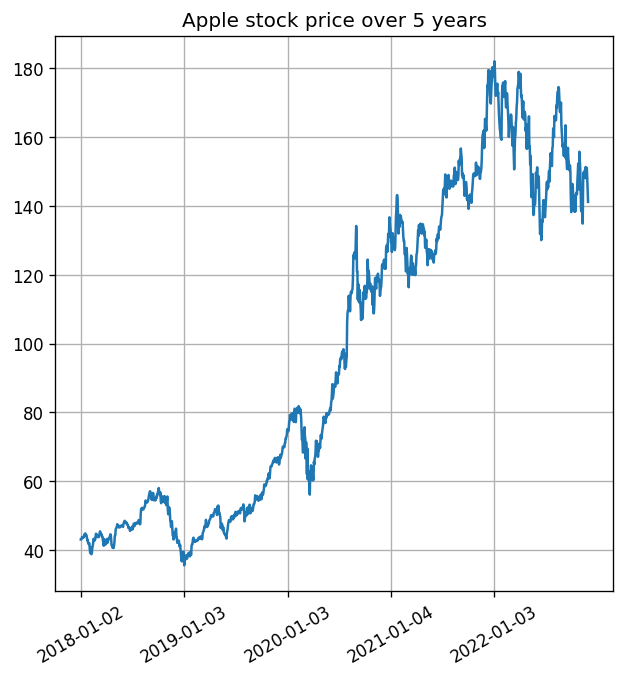

In [93]:
y = df['Close']
plt.figure(figsize=(6, 6))
plt.title('Apple stock price over 5 years')
plt.grid(True)
plt.xticks(np.arange(0, len(y), step=252), rotation=30)
plt.plot(y)
plt.show()

In [94]:
# First calculate the mid prices from the highest and lowest
high_prices = df['High']
low_prices = df['Low']
mid_prices = (high_prices+low_prices) / 2
len(mid_prices)

1237

In [95]:
# Check the stationarity of the model with an ADF
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(mid_prices.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.899537
p-value: 0.788125


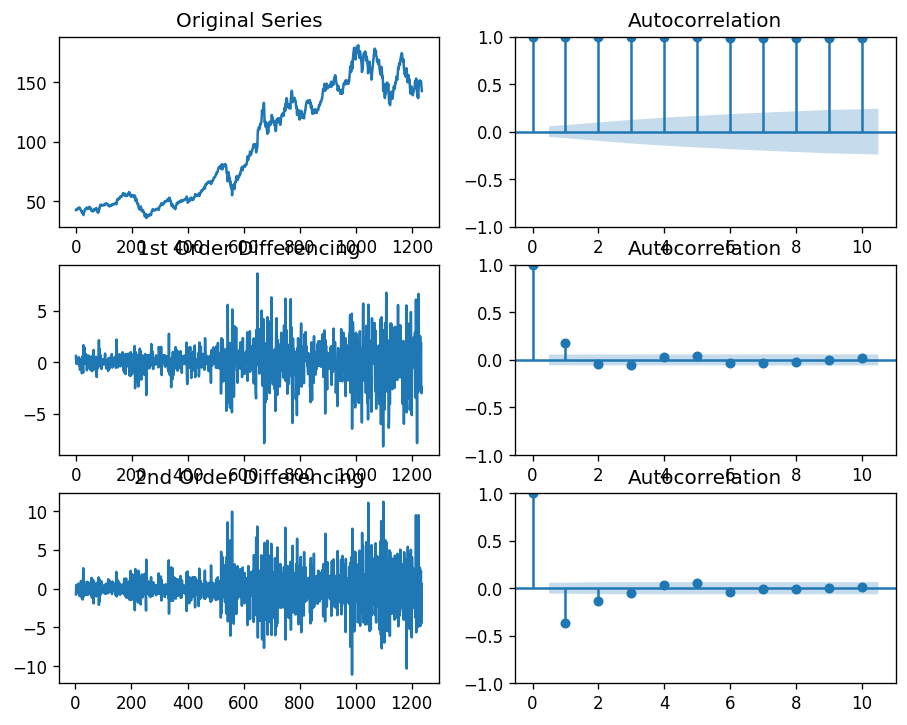

In [96]:
# As the p-value is above 0.05, we will differenciate the serie and check the autocorrelation plot
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
n_lags = 10

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(mid_prices.values); axes[0, 0].set_title('Original Series')
plot_acf(mid_prices.values, ax=axes[0, 1], lags=n_lags)

# 1st Differencing
axes[1, 0].plot(mid_prices.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(mid_prices.diff().dropna(), ax=axes[1, 1], lags=n_lags)

# 2nd Differencing
axes[2, 0].plot(mid_prices.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(mid_prices.diff().diff().dropna(), ax=axes[2, 1], lags=n_lags)

plt.show()

In [97]:
# Differentiate the signal once, to get the signal stationary
mid_prices = mid_prices.diff().dropna()

In [98]:
# We will keep the last 15 days of the dataset as a training set
n_elems = len(mid_prices)
batch_size = 15
test_size = batch_size * 2
train_data = mid_prices[:-test_size]
test_data = mid_prices[-test_size:]
print(train_data[:5])

Date
2018-01-03    0.618751
2018-01-04   -0.120001
2018-01-05    0.358750
2018-01-08    0.139999
2018-01-09   -0.133749
dtype: float64


In [99]:
# Scale the dataset
train_data = train_data.values
train_data = train_data.reshape(n_elems-test_size, 1)
test_data = test_data.values
test_data = test_data.reshape(test_size, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

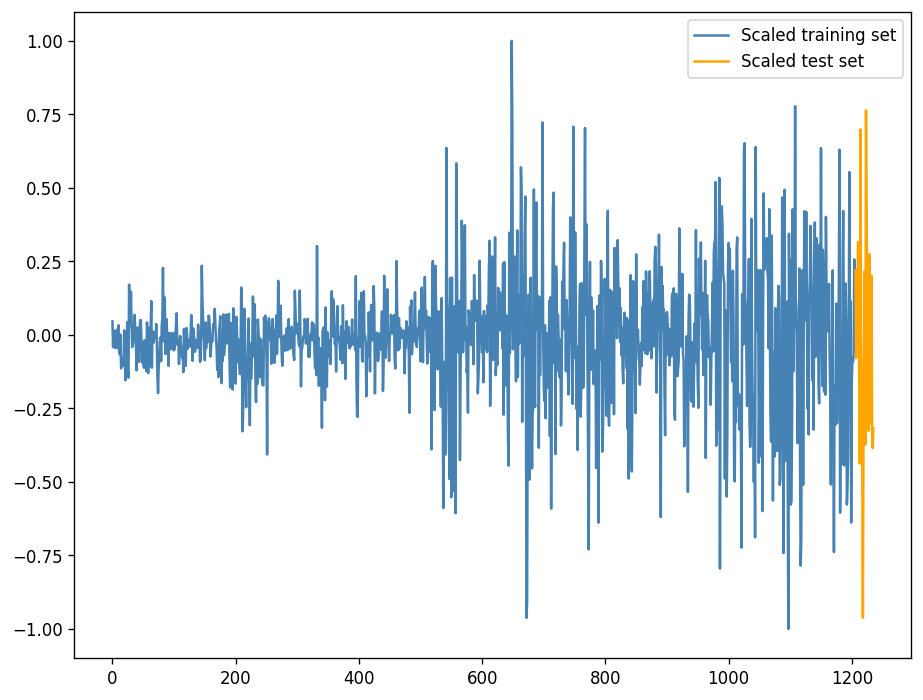

In [100]:
plt.plot(np.arange(len(train_data)), train_data, color='steelblue')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data, color='orange')

# you seemed to mess up the labels
plt.legend(['Scaled training set', 'Scaled test set'])
plt.show()

We must now prepare the batches of dataset for the LSTM. These batches will consist of three weeks of data, so 15 input data.

In [101]:
week_lenght = 5
train_X, train_y = [], []
for i in range(0, train_data.shape[0]-batch_size, week_lenght): 
        train_X.append(train_data[i:i+batch_size]) # each training sample is of length input hours
        train_y.append(train_data[i+batch_size][0]) # each y is just the next step after training sample

train_X = np.array(train_X) # format our new training set to keras format
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
train_y = np.array(train_y) # make sure y is an array to work properly with keras
train_X.shape

(239, 15, 1)

In [128]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# fit an LSTM network to training data
def fit_lstm(X, y, batch_size, nb_epochs, neurons):
    # X, y = train[:, 0:-1], train[:, -1]
    # X, y = train
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epochs, batch_size=batch_size, verbose=0)
    # for _ in range(nb_epoch):
    #     model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #     model.reset_states()
    return model

model = fit_lstm(train_X, train_y, batch_size=1, nb_epochs=100, neurons=10)

In [129]:
def forecast(model, batch_size, X_test, steps):
    X = X_test.copy().reshape(1,1,-1)
    X_list = X[0][0].tolist()
    
    for _ in range(steps):
        pred = model.predict(X, batch_size=batch_size)
        X_list.append(pred[0][0])
        # print(X_list[-batch_size:])
        X = np.array(X_list[-steps:]).reshape(1,1,-1) # replace first 11 values with 2nd through 12th
        # X[:,:,:-1] = pred # replace 12th value with prediction
        print(X)
    return X_list[-steps:]

steps = 15
preds = forecast(model, 1, test_data[:15], steps)

[[[-0.07880971  0.09765195  0.08987632  0.31538792  0.30880883
   -0.136235   -0.43711633  0.69881875  0.02287998 -0.12187837
   -0.47061501 -0.96171675 -0.29654562 -0.16076039  0.41644531]]]
[[[ 0.09765195  0.08987632  0.31538792  0.30880883 -0.136235
   -0.43711633  0.69881875  0.02287998 -0.12187837 -0.47061501
   -0.96171675 -0.29654562 -0.16076039  0.41644531 -0.24392557]]]
[[[ 0.08987632  0.31538792  0.30880883 -0.136235   -0.43711633
    0.69881875  0.02287998 -0.12187837 -0.47061501 -0.96171675
   -0.29654562 -0.16076039  0.41644531 -0.24392557 -0.02920121]]]
[[[ 0.31538792  0.30880883 -0.136235   -0.43711633  0.69881875
    0.02287998 -0.12187837 -0.47061501 -0.96171675 -0.29654562
   -0.16076039  0.41644531 -0.24392557 -0.02920121  0.3465398 ]]]
[[[ 0.30880883 -0.136235   -0.43711633  0.69881875  0.02287998
   -0.12187837 -0.47061501 -0.96171675 -0.29654562 -0.16076039
    0.41644531 -0.24392557 -0.02920121  0.3465398  -0.42469096]]]
[[[-0.136235   -0.43711633  0.69881875  0.

30
15


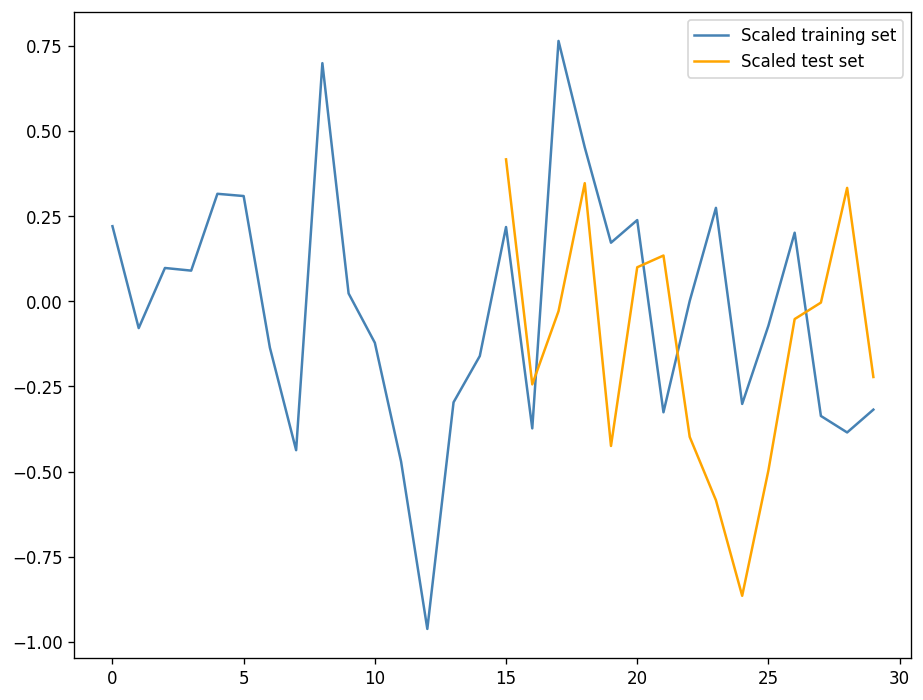

In [130]:
# print(test_data)
# test_list = test_data[0][0].tolist()
print(len(test_data))
print(len(preds))
plt.plot(np.arange(len(test_data)), test_data, color='steelblue')
plt.plot(np.arange(steps, steps + len(preds)), preds, color='orange')

# you seemed to mess up the labels
plt.legend(['Scaled training set', 'Scaled test set'])
plt.show()